### Physics-informed neural networks
In this notebook, I train a model to fit a sine curve on $[0, \pi]$ using noisy training data generated on $[0, 1]$. The differential equation used to model the sine curve was $u_{xx} + u = 0$.

### Importing libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
x_train = torch.rand((1000, 1))
y_train = torch.sin(x_train) + torch.randn((1000, 1)) / 5

In [ ]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(1, 30)
    self.layer2 = nn.Linear(30, 30)
    self.layer3 = nn.Linear(30, 1)
  def forward(self, x):
    x = self.layer1(x)
    x = F.gelu(x)
    x = self.layer2(x)
    x = F.gelu(x)
    x = self.layer3(x)
    return x

In [ ]:
def plot_network_predictions():
  plt.rcParams['figure.figsize'] = [3, 2]
  x = torch.linspace(0, np.pi, 100).reshape((-1, 1))
  y = torch.sin(x).reshape((-1, 1))
  y_pred = model(x)

  fig, ax = plt.subplots()

  ax.plot(x.numpy(), y.numpy(), linewidth=2.0)
  ax.plot(x.numpy(), y_pred.detach().numpy(), linewidth=2.0)

  ax.set(xlim=(0, np.pi), xticks=np.linspace(0, np.pi, 5),
        ylim=(-0.5, 1.5), yticks=np.linspace(-0.5, 1.5, 5))

  plt.show()

In [ ]:
def train(model, optimizer, loss_fn, num_epochs, batch_size):
  for epoch in range(1, num_epochs+1):
    total_loss = 0
    for batch in range(len(x_train) // batch_size):
      x = x_train[batch * batch_size : batch * batch_size + batch_size]
      y = y_train[batch * batch_size : batch * batch_size + batch_size]

      optimizer.zero_grad()
      y_pred = model(x)

      loss = loss_fn(y, y_pred)
      loss.backward()
      optimizer.step()

      total_loss += loss

    if (epoch % 10 == 0):
      # print(f"Epoch {epoch} loss: {total_loss.item()}")
      plot_network_predictions()

### Without physics-informed loss term

In [ ]:
model = MLP()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
num_epochs = 50
batch_size = 4

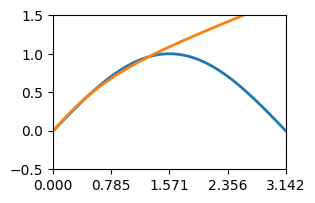

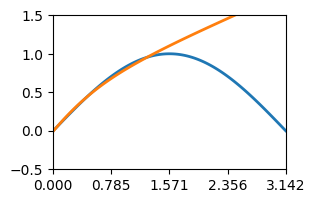

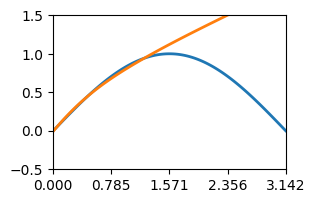

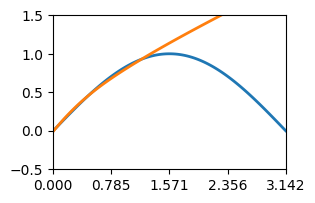

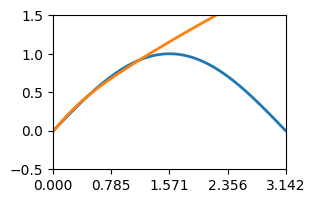

In [ ]:
loss_fn = nn.MSELoss()
train(model, optimizer, loss_fn, num_epochs, batch_size)

### With physics-informed loss term

In [ ]:
class PINN_Loss(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self, y_true, y_pred):
    x = torch.linspace(0, np.pi, 32).reshape(-1, 1)
    x.requires_grad_()
    u = model(x)
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x),create_graph=True)[0]
    u_0 = model(torch.Tensor([[0]]))
    u_pi = model(torch.Tensor([[np.pi]]))
    return F.mse_loss(y_true, y_pred) + F.mse_loss(torch.zeros(u.shape), (u + u_xx))

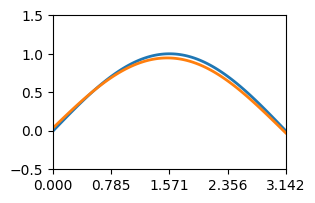

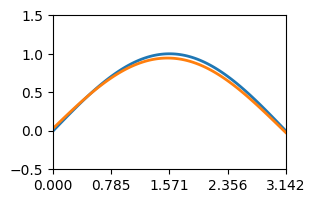

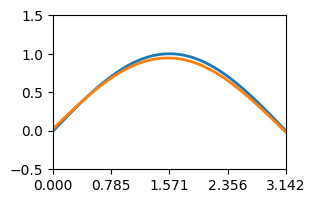

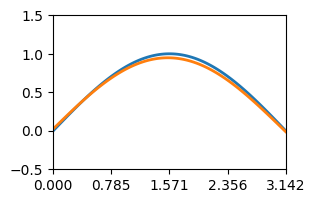

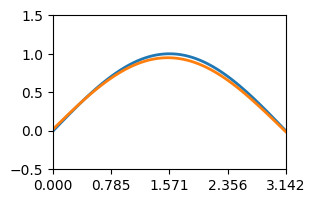

In [ ]:
model = MLP()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
num_epochs = 50
batch_size = 4

loss_fn = PINN_Loss()
train(model, optimizer, loss_fn, num_epochs, batch_size)